### Import necessary libraries

In [39]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Load Dataset

In [40]:
# Load and preprocess CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize the data
y_train_one_hot, y_test_one_hot = to_categorical(y_train, 10), to_categorical(y_test, 10)  # One-hot encode labels

# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

### Visualization

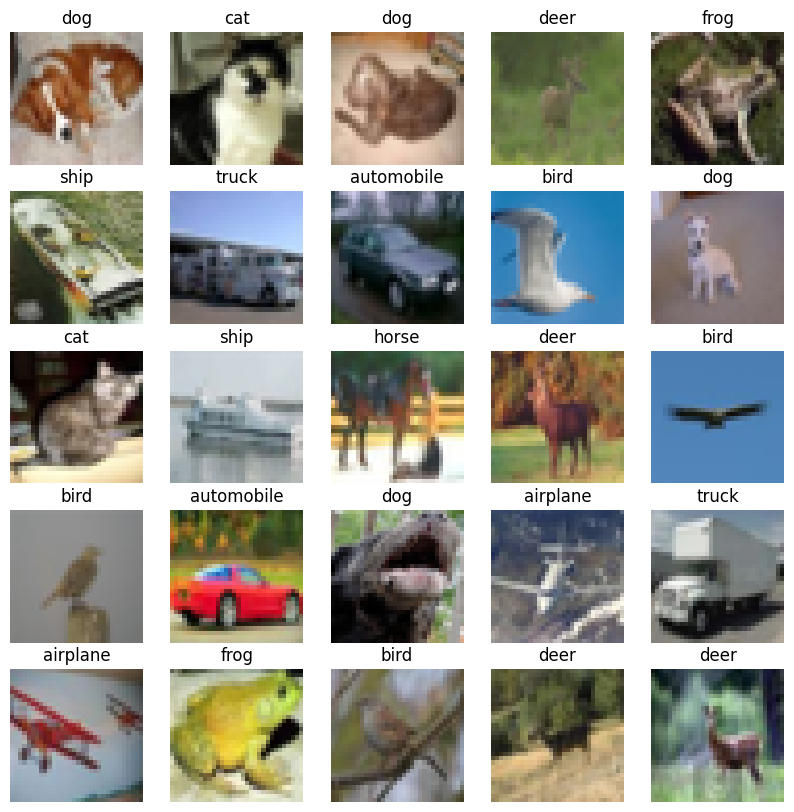

In [53]:
# Function to plot a grid of images
def plot_sample_images(x, y, num_images=25):
    plt.figure(figsize=(10, 10))

    # Select random indices for sample images
    indices = np.random.choice(range(x.shape[0]), num_images, replace=False)

    for i, idx in enumerate(indices):
        plt.subplot(5, 5, i + 1)
        plt.imshow(x[idx])
        plt.title(class_names[y[idx][0]])  # Use y[idx][0] to get class label
        plt.axis('off')

    plt.show()

# Plot sample images from the training set
plot_sample_images(x_train, y_train)

### Define CBAM Modules (Channel Attention and Spatial Attention)

In [41]:
# Channel Attention Module
def channel_attention(input_feature, ratio=9):
    channel = input_feature.shape[-1]
    shared_layer_one = layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
    shared_layer_two = layers.Dense(channel, kernel_initializer='he_normal', use_bias=True)

    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = layers.GlobalMaxPooling2D()(input_feature)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = layers.Add()([avg_pool, max_pool])
    cbam_feature = layers.Activation('sigmoid')(cbam_feature)

    return layers.Multiply()([input_feature, cbam_feature])

# Spatial Attention Module
class SpatialAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.conv = layers.Conv2D(filters=1, kernel_size=7, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        return inputs * self.conv(concat)

# CBAM Block
def cbam_block(cbam_feature, ratio=8):
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = SpatialAttention()(cbam_feature)
    return cbam_feature


### Define the CBAM-Enhanced CNN Model

In [42]:
# Build CBAM-enhanced CNN model
def build_cbam_cnn(input_shape=(32, 32, 3), num_classes=10):
    model_input = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(model_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = cbam_block(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = cbam_block(x)

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = cbam_block(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=model_input, outputs=x)
    return model

# Compile the model
model = build_cbam_cnn(input_shape=(32, 32, 3), num_classes=10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 32, 32, 32)     │            896 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_21          │ (None, 16, 16, 32)     │              0 │ conv2d_33[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 32)             │              0 │ max_pooling2d_21[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_12   │ (None, 32)             │              0 │ max_pooling2d_21[0][0] │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_24 (Reshape)      │ (None, 1, 1, 32)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_25 (Reshape)      │ (None, 1, 1, 32)       │              0 │ global_max_pooling2d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_39 (Dense)          │ (None, 1, 1, 4)        │            132 │ reshape_24[0][0],      │
│                           │                        │                │ reshape_25[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_40 (Dense)          │ (None, 1, 1, 32)       │            160 │ dense_39[0][0],        │
│                           │                        │                │ dense_39[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 1, 1, 32)       │              0 │ dense_40[0][0],        │
│                           │                        │                │ dense_40[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_12             │ (None, 1, 1, 32)       │              0 │ add_12[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_12 (Multiply)    │ (None, 16, 16, 32)     │              0 │ max_pooling2d_21[0][0… │
│                           │                        │                │ activation_12[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_attention_12      │ (None, 16, 16, 32)     │             98 │ multiply_12[0][0]      │
│ (SpatialAttention)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 16, 16, 64)     │         18,496 │ spatial_attention_12[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_22     

 Total params: 370,348 (1.41 MB)

 Trainable params: 370,348 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model and Track Accuracy

In [44]:
# Train the model and store history for accuracy plot
history = model.fit(x_train, y_train_one_hot, epochs=20, batch_size=64, validation_data=(x_test, y_test_one_hot))


Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.2772 - loss: 1.9518 - val_accuracy: 0.4748 - val_loss: 1.4347
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5021 - loss: 1.3663 - val_accuracy: 0.5554 - val_loss: 1.2155
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5865 - loss: 1.1571 - val_accuracy: 0.6205 - val_loss: 1.0619
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6365 - loss: 1.0123 - val_accuracy: 0.6529 - val_loss: 0.9879
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6889 - loss: 0.8897 - val_accuracy: 0.6816 - val_loss: 0.9135
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7158 - loss: 0.8119 - val_accuracy: 0.6907 - val_loss: 0.8848
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7421 - loss: 0.7339 - val_accuracy: 0.6853 - val_loss: 0.9167
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7618 - loss: 0.6735 - val_accuracy: 

### Plot Training and Validation Accuracy

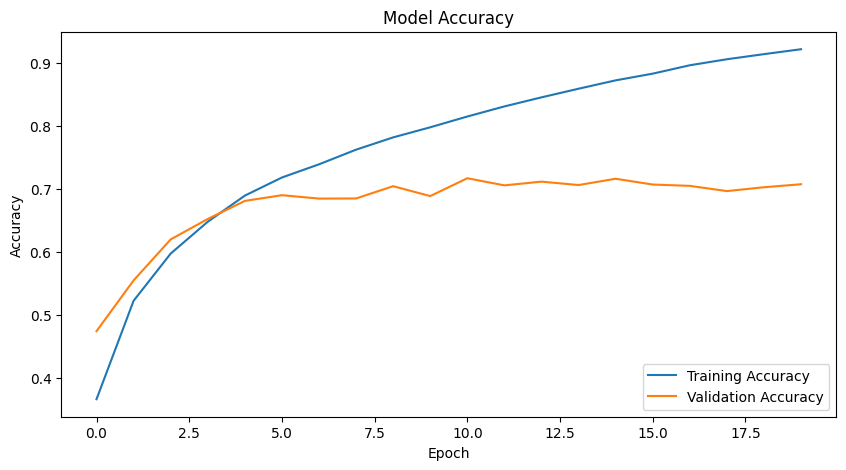

In [45]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Evaluate the Model and Generate Classification Report

In [46]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test_one_hot, verbose=0)
print(f"Test accuracy: {test_acc:.2f}")

# Predict classes and generate a classification report
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test.flatten()
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=class_names))


Test accuracy: 0.71
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Classification Report:
               precision    recall  f1-score   support

    airplane       0.68      0.79      0.73      1000
  automobile       0.81      0.84      0.82      1000
        bird       0.60      0.64      0.62      1000
         cat       0.55      0.49      0.52      1000
        deer       0.66      0.63      0.65      1000
         dog       0.62      0.61      0.61      1000
        frog       0.79      0.75      0.77      1000
       horse       0.76      0.75      0.76      1000
        ship       0.81      0.80      0.81      1000
       truck       0.80      0.77      0.78      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000



### Plot Confusion Matrix

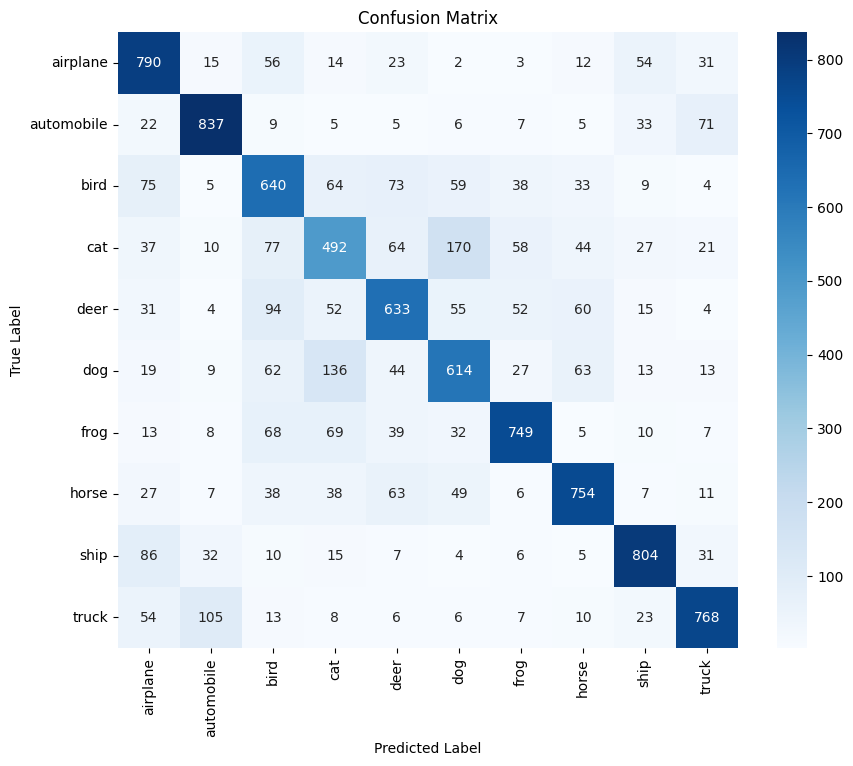

In [47]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Traditional CNN Model

In [54]:
# Build traditional CNN model
def build_traditional_cnn(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Compile the traditional CNN model
traditional_model = build_traditional_cnn(input_shape=(32, 32, 3), num_classes=10)
traditional_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
traditional_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 128)                 │         921,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 923,914 (3.52 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Train the traditional CNN model and store history for accuracy plot
traditional_history = traditional_model.fit(x_train, y_train_one_hot, epochs=20, batch_size=64, validation_data=(x_test, y_test_one_hot))


Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.3619 - loss: 1.7799 - val_accuracy: 0.5490 - val_loss: 1.2976
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5594 - loss: 1.2466 - val_accuracy: 0.5853 - val_loss: 1.1774
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6079 - loss: 1.1225 - val_accuracy: 0.5855 - val_loss: 1.1683
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6366 - loss: 1.0369 - val_accuracy: 0.5996 - val_loss: 1.1307
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6616 - loss: 0.9717 - val_accuracy: 0.6279 - val_loss: 1.0559
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6794 - loss: 0.9174 - val_accuracy: 0.6300 - val_loss: 1.0571
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6998 - loss: 0.8648 - val_accuracy: 0.6433 - val_loss: 1.0176
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7126 - loss: 0.8281 - val_accuracy: 0.

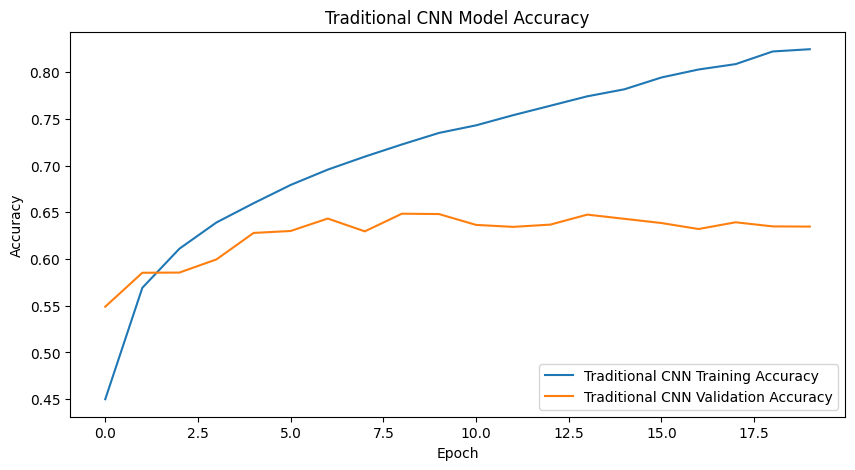

In [56]:
# Plot training & validation accuracy values for traditional CNN
plt.figure(figsize=(10, 5))
plt.plot(traditional_history.history['accuracy'], label='Traditional CNN Training Accuracy')
plt.plot(traditional_history.history['val_accuracy'], label='Traditional CNN Validation Accuracy')
plt.title('Traditional CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [57]:
# Evaluate the traditional CNN model
test_loss, test_acc = traditional_model.evaluate(x_test, y_test_one_hot, verbose=0)
print(f"Traditional CNN Test accuracy: {test_acc:.2f}")

# Predict classes and generate a classification report
y_pred_traditional = traditional_model.predict(x_test)
y_pred_classes_traditional = np.argmax(y_pred_traditional, axis=1)
y_true_classes = y_test.flatten()
print("Classification Report for Traditional CNN:\n", classification_report(y_true_classes, y_pred_classes_traditional, target_names=class_names))


Traditional CNN Test accuracy: 0.63
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report for Traditional CNN:
               precision    recall  f1-score   support

    airplane       0.66      0.67      0.66      1000
  automobile       0.84      0.66      0.74      1000
        bird       0.45      0.56      0.50      1000
         cat       0.42      0.49      0.45      1000
        deer       0.59      0.57      0.58      1000
         dog       0.56      0.49      0.52      1000
        frog       0.77      0.68      0.73      1000
       horse       0.72      0.69      0.70      1000
        ship       0.76      0.75      0.76      1000
       truck       0.69      0.79      0.74      1000

    accuracy                           0.63     10000
   macro avg       0.65      0.63      0.64     10000
weighted avg       0.65      0.63      0.64     10000



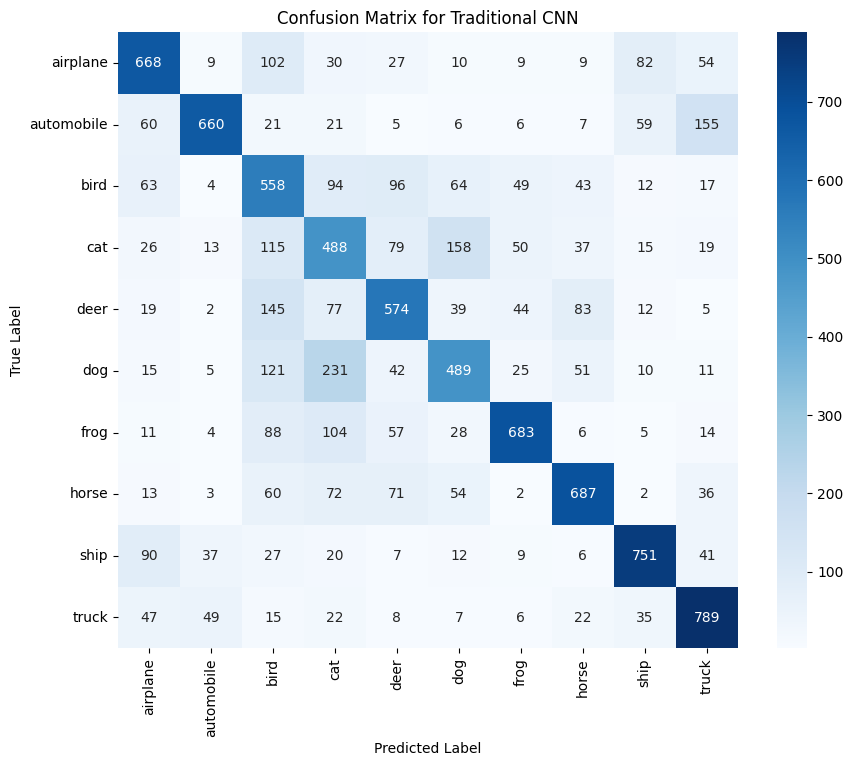

In [58]:
# Confusion Matrix for Traditional CNN
conf_matrix_traditional = confusion_matrix(y_true_classes, y_pred_classes_traditional)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_traditional, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Traditional CNN')
plt.show()


### Traditional CNN Test accuracy: 0.63
### CBAM-enhanced CNN model Test accuracy : 0.71